In [37]:
from netCDF4 import Dataset
import datetime
import matplotlib
import pandas as pd
import os
import numpy as np
from scipy.signal import argrelextrema
import pickle
from ll_xy import lonlat_to_xy
import warnings
import matplotlib.pyplot as plt
import kuka_tools as kt
# You can find kuka_tools at https://github.com/robbiemallett/custom_modules/blob/master/kuka_tools.py

In [38]:
directory = '/media/robbie/One Touch/KUKA/PROCESSED/20231006'

pits = {}

# Field book five p7

Text(0, 0.5, 'y distance (m)')

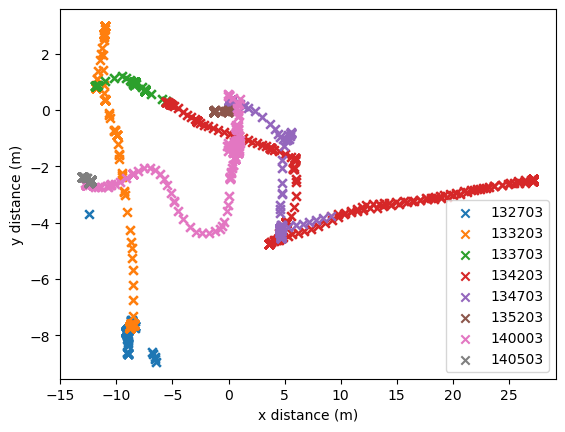

In [39]:
x0,y0 = 0,0

def plot_pos(file,plot=True,x0=0,y0=0):
    
    d = Dataset(f'{directory}/{file}')
    x, y = kt.lonlat_to_xy(np.array(d['lon']), np.array(d['lat']),hemisphere='s')
    y = y[np.abs(x)>10_000] -y0
    x = x[np.abs(x)>10_000] -x0
    if plot:
        plt.scatter(x,y,marker='x',label=file[-9:-3])

    return (x,y)

x,y=plot_pos('kuka_stare_decon_Ka-Scat20231006-135203.nc',plot=False)

x0 = x[0]; y0 = y[0]


plot_pos('kuka_stare_decon_Ka-Scat20231006-132703.nc',x0=x0,y0=y0)
plot_pos('kuka_stare_decon_Ka-Scat20231006-133203.nc',x0=x0,y0=y0)
plot_pos('kuka_stare_decon_Ka-Scat20231006-133703.nc',x0=x0,y0=y0)
plot_pos('kuka_stare_decon_Ka-Scat20231006-134203.nc',x0=x0,y0=y0)
plot_pos('kuka_stare_decon_Ka-Scat20231006-134703.nc',x0=x0,y0=y0)
plot_pos('kuka_stare_decon_Ka-Scat20231006-135203.nc',x0=x0,y0=y0)

plot_pos('kuka_stare_decon_Ka-Scat20231006-140003.nc',x0=x0,y0=y0)
plot_pos('kuka_stare_decon_Ka-Scat20231006-140503.nc',x0=x0,y0=y0)


plt.legend()
plt.xlabel('x distance (m)')
plt.ylabel('y distance (m)')

# plt.xlim(-20,5)
# plt.ylim(-20,5)

In [40]:
pits = {}

In [41]:
# # Offset between Ka & ku
fa = 'kuka_stare_decon_Ka-Scat20231006-140503.nc'

fu = 'kuka_stare_decon_Ku-Scat20231006-140307.nc'

ka = Dataset(f'{directory}/{fa}')['start_time'][0]
ku = Dataset(f'{directory}/{fu}')['start_time'][0]
kuka_offset = ka-ku
kuka_offset

116.05424094200134

datetime.timedelta(seconds=50708)

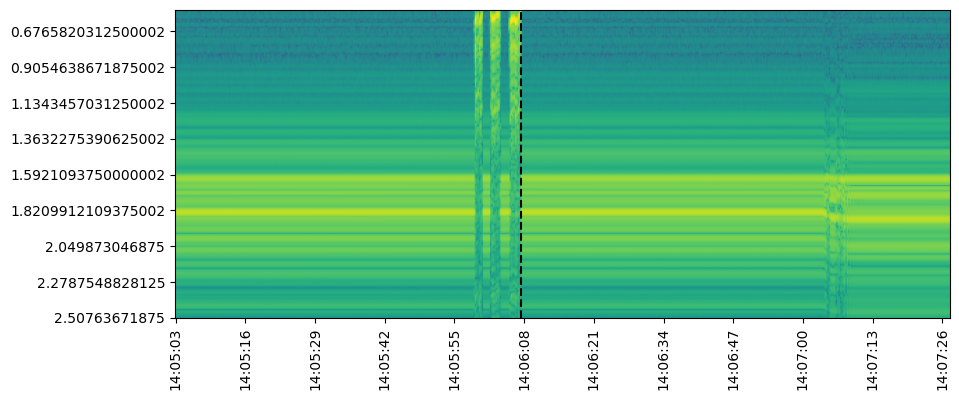

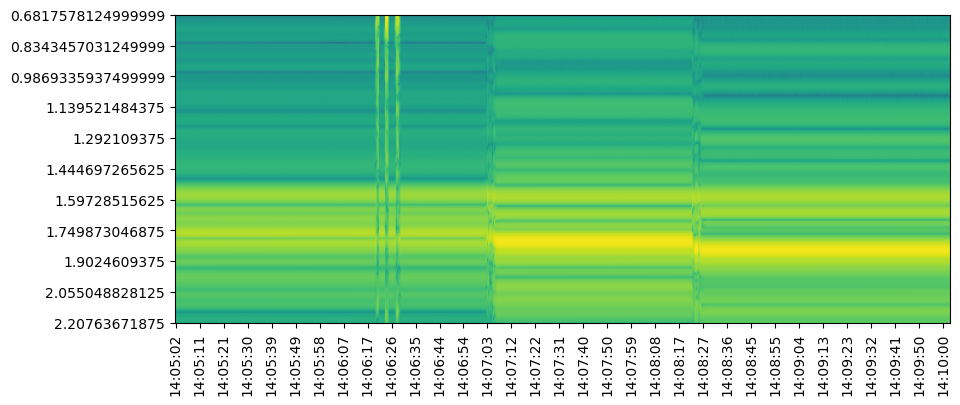

In [42]:
fa = 'kuka_stare_decon_Ka-Scat20231006-140503.nc'

fu = 'kuka_stare_decon_Ku-Scat20231006-140307.nc'

time_addition = datetime.timedelta(seconds=0)

ka_times = [(6,8)]
vlines = [datetime.datetime(2023,10,6,14,a,b)+time_addition for (a,b) in ka_times]
            # (30,30), (31,12)

kt.plot_file(fa,'ka',time_offset_s=0,vlines = vlines,directory=directory)

ku_times = []
vlines = [datetime.datetime(2023,10,2,11,a,b)+time_addition for (a,b) in ku_times]

kt.plot_file(fu,'ku',time_offset_s=-0+115,vlines=vlines,directory=directory)

# Voice recording indicates that 10:37:55 kuka time is equal to 07:46:04 on phone

local_delta = datetime.datetime(2023,10,6,14,6,8)-datetime.datetime(2023,10,6,0,1,0)
local_delta

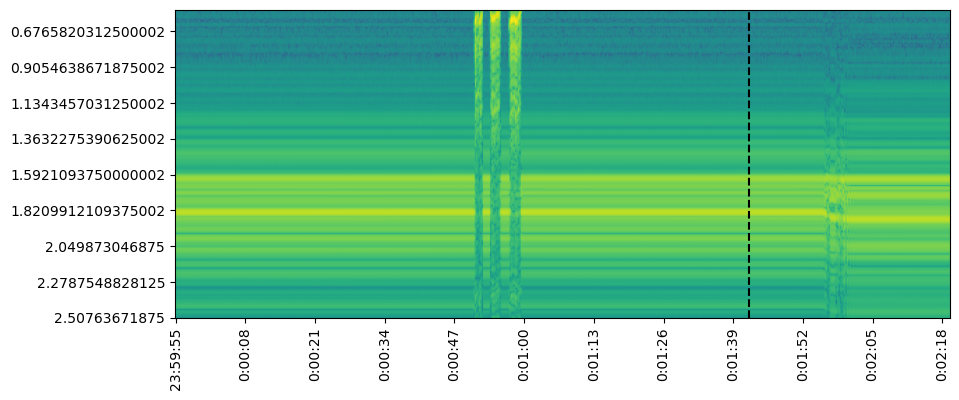

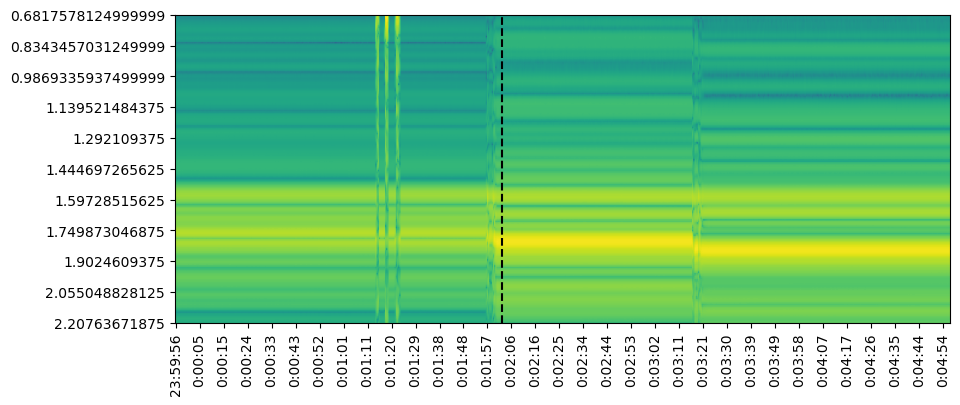

In [43]:
fa = 'kuka_stare_decon_Ka-Scat20231006-140503.nc'

fu = 'kuka_stare_decon_Ku-Scat20231006-140307.nc'

time_addition = datetime.timedelta(seconds=0)

ka_times = [(1,42)]
vlines = [datetime.datetime(2023,10,6,0,a,b)+time_addition for (a,b) in ka_times]
            # (30,30), (31,12)

ka_inds = kt.plot_file(fa,'ka',time_offset_s=-local_delta.seconds,vlines = vlines,directory=directory)

# ku_times = [(1,22),(2,3)]

ku_times = [(2,3)]
vlines = [datetime.datetime(2023,10,6,0,a,b)+time_addition for (a,b) in ku_times]

ku_inds = kt.plot_file(fu,'ku',time_offset_s=-local_delta.seconds+kuka_offset,vlines=vlines,directory=directory)

pit_numbers = [1]


ku_files = [fu]*len(pit_numbers)
ka_files = [fa]*len(pit_numbers)


for pitno, ka_ind, ku_ind, ka_file, ku_file in zip(pit_numbers,ka_inds,ku_inds,ka_files,ku_files):

    pits[pitno] = {}
    pits[pitno]['ka'] = ka_ind
    pits[pitno]['ku'] = ku_ind
    pits[pitno]['ka_file'] = ka_file
    pits[pitno]['ku_file'] = ku_file

In [44]:
pols = ['hh','vv','hv','vh']

for pitno, data_dict in pits.items():

    y,m,day = kt.get_ymd_from_filename(pits[pitno]['ku_file'])
    
    for freq in ['ka','ku']:

        with Dataset(f'{directory}/{data_dict[f"{freq}_file"]}') as d:
            
            ranges = np.array(d['range'])

            start_ind = pits[pitno][freq]
            end_ind = start_ind+5

            for pol in pols:
            
                pits[pitno][f'{freq}_{pol}'] = np.mean(np.array(d[f'{pol}_power_decon0'])[:,start_ind:start_ind+5],axis=1)
                pits[pitno][f'{freq}_range'] = ranges

In [45]:
for freq in ['ka','ku']:

    for h in pits.keys():
    
        data = pits[h]
    
        dic = {pol:data[f'{freq}_{pol}'] for pol in pols}
        
        wvfms = pd.DataFrame(dic)
    
        wvfms.to_csv(f'../data/waveforms/Hangar_2023106_single_pit_{freq}.csv')